In [198]:
import pandas as pd
from sklearn.model_selection import train_test_split

data = pd.read_csv('train_dataset.csv')

In [199]:
import numpy as np

names_train = ['features_countvec/train_countvec_features_actor_1_name.npy', 'features_countvec/train_countvec_features_actor_2_name.npy', 
               'features_countvec/train_countvec_features_director_name.npy', 'features_doc2vec/train_doc2vec_features_genre.npy',
               'features_doc2vec/train_doc2vec_features_plot_keywords.npy', 'features_fasttext/train_fasttext_title_embeddings.npy']

for name in names_train:
    print(name)
    print(len(np.load(name)[0]))

features_countvec/train_countvec_features_actor_1_name.npy
2063
features_countvec/train_countvec_features_actor_2_name.npy
2919
features_countvec/train_countvec_features_director_name.npy
2113
features_doc2vec/train_doc2vec_features_genre.npy
100
features_doc2vec/train_doc2vec_features_plot_keywords.npy
100
features_fasttext/train_fasttext_title_embeddings.npy
100


In [200]:
def create_columns(len, unique):
    columns = []
    for i in range(len):
        columns.append(str(i + unique))
    return columns

In [201]:
temp1 = np.load('features_countvec/train_countvec_features_actor_1_name.npy')
df_act_1 = pd.DataFrame(temp1, columns=create_columns(len(temp1[0]), 0))

temp2 = np.load('features_countvec/train_countvec_features_actor_2_name.npy')
df_act_2 = pd.DataFrame(temp2, columns=create_columns(len(temp2[0]), len(temp1[0])))

temp3 = np.load('features_countvec/train_countvec_features_director_name.npy')
df_dir = pd.DataFrame(temp3, columns=create_columns(len(temp3[0]), len(temp1[0]) + len(temp2[0])))

temp4 = np.load('features_doc2vec/train_doc2vec_features_genre.npy')
df_genre = pd.DataFrame(temp4, columns=create_columns(len(temp4[0]), len(temp1[0]) + len(temp2[0]) + 100))

temp5 = np.load('features_doc2vec/train_doc2vec_features_plot_keywords.npy')
df_keyword = pd.DataFrame(temp5, columns=create_columns(len(temp5[0]), len(temp1[0]) + len(temp2[0]) + 200))

temp6 = np.load('features_fasttext/train_fasttext_title_embeddings.npy')
df_title = pd.DataFrame(temp6, columns=create_columns(len(temp6[0]), len(temp1[0]) + len(temp2[0]) + 300))

In [202]:
df_list = [df_act_1, df_act_2, df_dir, df_genre, df_keyword, df_title]
pre_data = pd.concat(df_list, axis=1)

data_new = pd.concat([data, pre_data], axis=1)

In [203]:
X_train, X_test, y_train, y_test = train_test_split(data_new.drop(columns='imdb_score_binned'), data_new['imdb_score_binned'], test_size=0.3, random_state=42)
#X_train = X_train.reset_index()
#X_test = X_test.reset_index()
#y_train = y_train.reset_index()
#y_test = y_test.reset_index()

In [204]:
X_train['country'].value_counts()

country
USA              1678
UK                171
France             58
Germany            46
Canada             32
Australia          25
Spain              14
Hong Kong           8
New Zealand         8
Denmark             6
Italy               6
China               5
South Korea         5
Japan               4
Ireland             3
Thailand            3
South Africa        3
Mexico              3
Brazil              2
Romania             2
Norway              2
Netherlands         2
Finland             1
Iran                1
Argentina           1
India               1
Aruba               1
Russia              1
Hungary             1
Chile               1
Poland              1
Belgium             1
Official site       1
West Germany        1
Israel              1
New Line            1
Taiwan              1
Iceland             1
Name: count, dtype: int64

In [205]:
X_train['language'].value_counts()

language
English       2016
French          22
Spanish         11
German           7
Cantonese        5
Mandarin         5
Italian          4
Danish           3
Japanese         3
Thai             2
Portuguese       2
Korean           2
Dutch            2
Norwegian        2
Aboriginal       2
Persian          1
Bosnian          1
Hindi            1
Zulu             1
Hungarian        1
Aramaic          1
Romanian         1
Filipino         1
Maya             1
Hebrew           1
Arabic           1
Kazakh           1
Dari             1
Name: count, dtype: int64

In [206]:
train_pre_data = X_train.iloc[:, 26:]

In [207]:
#from sklearn.decomposition import PCA
#PCs = [200, 400, 600, 800, 1000, 1500, 2000, 3000]
#var = []
#for n in PCs:

#    pca = PCA(n_components=n)

#    df_list = [df_act_1, df_act_2, df_dir, df_genre, df_keyword, df_title]
#    train_pre_data = pd.concat(df_list, axis=1)

#    columns = []
#    for i in range(n):
#        columns.append(str(i))

#    principalComponents = pca.fit_transform(train_pre_data)

#    var.append(np.var(principalComponents))
#import matplotlib.pyplot as plt
#cum_var = np.cumsum(var)

#plt.xlabel('Principal Components')
#plt.ylabel('Cumulative Explained Variance')
#plt.plot(PCs, cum_var)
#plt.show()

In [208]:
# Implement PCA to cut down columns further
from sklearn.decomposition import PCA

n1 = 50

pca = PCA(n_components=n1)

columns = []
for i in range(n1):
    columns.append(str(i))

principalComponents = pca.fit_transform(train_pre_data)

df_pca = pd.DataFrame(data=principalComponents, columns=columns)

In [209]:
#from sklearn.feature_selection import RFE
#from sklearn.tree import DecisionTreeClassifier

# Number of columns to reduce sparse matrices to
#n=100

#selector = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=n, step=10)
#X_train_RFE = selector.fit_transform(df_pca, y_train)

In [210]:
#columns = []
#for i in range(n):
#    columns.append(str(i))

#df_selected_train = pd.DataFrame(data=X_train_RFE, columns=columns)

In [211]:
# Drop old columns and unnecessary columns
titles = ['actor_1_name', 'actor_2_name', 'director_name', 'genres', 'plot_keywords', 'language', 'country', 'id',
            'title_embedding', 'movie_title', 'actor_3_name', 'actor_3_facebook_likes']
df_temp = X_train.iloc[:, :26].drop(columns=titles)
train_new = pd.concat([df_temp.reset_index(), df_pca.reset_index()], axis=1)

In [212]:
X_train['content_rating'].value_counts()

content_rating
R            957
PG-13        748
PG           305
G             44
Not Rated     20
Unrated        8
Approved       8
X              7
NC-17          2
M              1
Passed         1
GP             1
Name: count, dtype: int64

In [213]:
# Combine ratings
X_train.loc[X_train.content_rating == 'GP', 'content_rating'] = 'G'
X_train.loc[X_train.content_rating == 'Passed', 'content_rating'] = 'Approved'
X_train.loc[X_train.content_rating == 'NC-17', 'content_rating'] = 'X'
X_train.loc[X_train.content_rating == 'Not Rated', 'content_rating'] = 'Unrated'
X_train.loc[X_train.content_rating == 'M', 'content_rating'] = 'PG-13'

X_train['content_rating'].value_counts()

content_rating
R           957
PG-13       749
PG          305
G            45
Unrated      28
X             9
Approved      9
Name: count, dtype: int64

In [214]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
encoded = enc.fit_transform(X_train[['content_rating']])

df_temp = pd.DataFrame(encoded.toarray(), columns=['Approved', 'G', 'PG', 'PG-13', 'R', 'Unrated', 'X'])

train_final = pd.concat([train_new.drop(columns=['content_rating']), df_temp], axis=1)

In [215]:
test_pre_data = X_test.iloc[:, 26:]

In [216]:
# Apply fitted PCA to test data
test_pcs = pca.transform(test_pre_data)

columns = []
for i in range(n1):
    columns.append(str(i))

df_pca_test = pd.DataFrame(data=test_pcs, columns=columns)

In [217]:
#X_test_RFE = selector.transform(df_pca_test)

In [218]:
#columns = []
#for i in range(n):
#    columns.append(str(i))

#df_selected_test = pd.DataFrame(data=X_test_RFE, columns=columns)

In [219]:
test_new = pd.concat([X_test.iloc[:, :26].drop(columns=titles).reset_index(), df_pca_test.reset_index()], axis=1)

print(len(test_new.columns))

116


In [220]:
# Combine ratings
X_test.loc[X_test.content_rating == 'GP', 'content_rating'] = 'G'
X_test.loc[X_test.content_rating == 'Passed', 'content_rating'] = 'Approved'
X_test.loc[X_test.content_rating == 'NC-17', 'content_rating'] = 'X'
X_test.loc[X_test.content_rating == 'Not Rated', 'content_rating'] = 'Unrated'
X_test.loc[X_test.content_rating == 'M', 'content_rating'] = 'PG-13'

encoded = enc.transform(X_test[['content_rating']])

df_temp = pd.DataFrame(encoded.toarray(), columns=['Approved', 'G', 'PG', 'PG-13', 'R', 'Unrated', 'X'])

test_new = pd.concat([test_new.drop(columns='content_rating'), df_temp], axis=1)

In [221]:
# Apply post processing, ie normalisation, standardisation
# Remove outliers
#from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
#MinMax = MinMaxScaler()
Standard = StandardScaler()

X_stan = Standard.fit_transform(train_final)
X_test_stan = Standard.transform(test_new)

#X_minmax = MinMax.fit_transform(train_final)
#X_test_minmax = MinMax.transform(test_new)

In [222]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
from xgboost import XGBClassifier

accuracy = []

In [223]:
forest = RandomForestClassifier(random_state=0).fit(X_stan, y_train)
y_forest = forest.predict(X_test_stan)

accuracy.append(accuracy_score(y_test, y_forest))

In [224]:
XGB = XGBClassifier(random_state=0).fit(X_stan, y_train)
y_XGB = XGB.predict(X_test_stan)

accuracy.append(accuracy_score(y_test, y_XGB))

In [225]:
GTB = GradientBoostingClassifier(random_state=0).fit(X_stan, y_train)
y_GTB = GTB.predict(X_test_stan)

accuracy.append(accuracy_score(y_test, y_GTB))

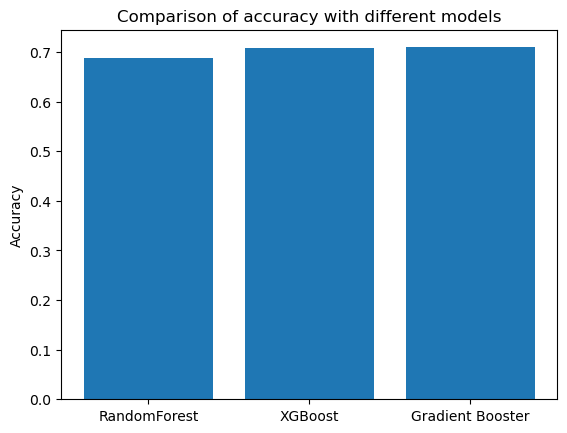

In [226]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots()
models = ['RandomForest', 'XGBoost', 'Gradient Booster']
ax.bar(models, accuracy)
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of accuracy with different models')
plt.show()

In [233]:
XGB = XGBClassifier(max_depth=4, random_state=0).fit(X_stan, y_train)
y_XGB = XGB.predict(X_test_stan)

In [234]:
print(accuracy_score(y_test, y_XGB))
print(f1_score(y_test, y_XGB, average='weighted'))
print(precision_score(y_test, y_XGB, average='weighted'))
print(recall_score(y_test, y_XGB, average='weighted'))
# There is a large label imbalance so we will go with weighted average instead of macro

0.7239467849223947
0.6938913075698062
0.7007035182569505
0.7239467849223947


/home/zac/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [229]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_XGB)

print(cm)


[[  0   1   5   0   0]
 [  0   0  73   0   0]
 [  0   2 515  37   0]
 [  0   1 134  93   7]
 [  0   0   3  10  21]]


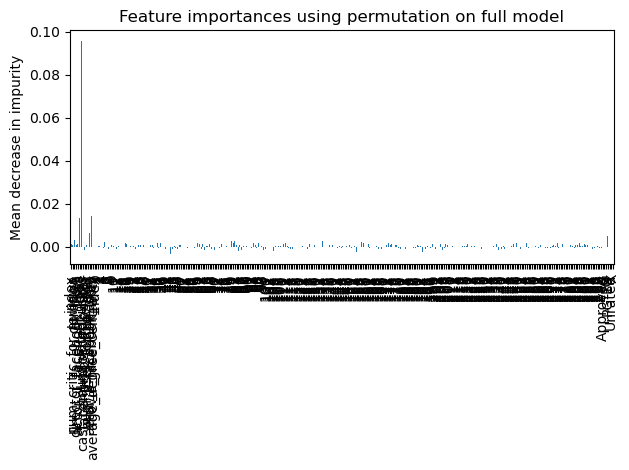

In [154]:
from sklearn.inspection import permutation_importance
result = permutation_importance(GTB, X_test_stan, y_test, n_repeats=10, random_state=42, n_jobs=2)

gtb_importances = pd.Series(result.importances_mean, index=test_new.columns)

fig, ax = plt.subplots()
gtb_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [155]:
count = 0
remove_features = []
for i in range(len(gtb_importances)):
    if (gtb_importances[i] < 0):
        remove_features.append(test_new.columns[i])
        count = count + 1
print(count)

126


/tmp/ipykernel_22772/2999330604.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (gtb_importances[i] < 0):


In [156]:
print(remove_features)

['facenumber_in_poster', '3', '4', '7', '12', '14', '15', '19', '21', '23', '34', '35', '37', '41', '43', '44', '45', '47', '48', '51', '54', '55', '57', '58', '62', '64', '68', '70', '73', '75', '84', '86', '90', '91', '92', '95', '97', '99', '100', '103', '105', '107', '110', '114', '115', '116', '119', '120', '124', '125', '127', '128', '130', '131', '133', '137', '139', '141', '142', '143', '145', '151', '154', '155', '159', '160', '162', '167', '168', '169', '176', '179', '180', '182', '183', '185', '186', '187', '188', '189', '193', '195', '198', '200', '201', '202', '205', '206', '209', '212', '213', '214', '216', '228', '229', '231', '232', '233', '234', '236', '238', '239', '240', '242', '243', '244', '245', '251', '253', '256', '258', '259', '261', '262', '266', '267', '268', '269', '274', '275', '277', '283', '294', '295', '298', '299']


In [759]:
X_norm_test_dropped = pd.DataFrame(X_test_stan, columns=test_new.columns).drop(columns=remove_features)

X_norm_dropped = pd.DataFrame(X_stan, columns=test_new.columns).drop(columns=remove_features)

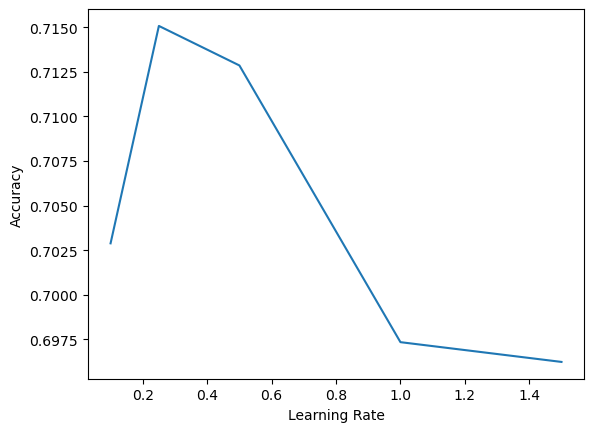

In [230]:
# Evaluate effectiveness of Gradient Boosting model
from matplotlib import pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score


learning_rate = [1.5, 1, 0.5, 0.25, 0.1]
y_pred_learning = []
for rate in learning_rate:
    model = XGBClassifier(learning_rate=rate).fit(X_stan, y_train)
    y_pred = model.predict(X_test_stan)
    y_pred_learning.append(accuracy_score(y_test, y_pred))

plt.plot(learning_rate, y_pred_learning)
plt.ylabel('Accuracy')
plt.xlabel('Learning Rate')
plt.show()

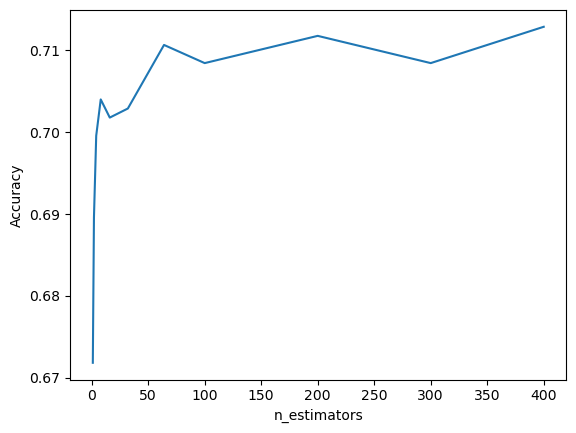

In [231]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200, 300, 400]
y_pred_est = []
for n in n_estimators:
    model = XGBClassifier(n_estimators=n).fit(X_stan, y_train)
    y_pred = model.predict(X_test_stan)
    y_pred_est.append(accuracy_score(y_test, y_pred))

plt.plot(n_estimators, y_pred_est)
plt.ylabel('Accuracy')
plt.xlabel('n_estimators')
plt.show()

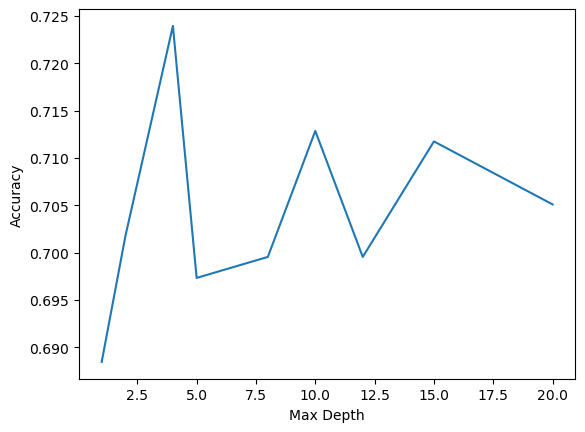

In [232]:
depths = [1, 2, 4, 5, 8, 10, 12, 15, 20]
y_pred_depth = []
for depth in depths:
    model = XGBClassifier(max_depth=depth).fit(X_stan, y_train)
    y_pred = model.predict(X_test_stan)
    y_pred_depth.append(accuracy_score(y_test, y_pred))

plt.plot(depths, y_pred_depth)
plt.ylabel('Accuracy')
plt.xlabel('Max Depth')
plt.show()